In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import skimage.segmentation as seg
import skimage.color as color
import pickle

%matplotlib inline

In [3]:
df = pd.read_pickle("/home/maksim/Documents/Itten_files/new_abstract_7.pkl")
df

,Art,Author,Paths,normalized_price,square_m,ExhibitedNum,ProvenanceNum,LiteratureNum,date_of_birth,oil,...,X_rectangle,X_analog_triad,X_quad,X_comp,ccm,points_of_interest,mean_h,mean_s,mean_v,edge_density
0,UNTITLED,franz kline,/home/maksim/Documents/Abstract_Images_cropped...,9.005157,-0.496600,-0.129774,-0.407388,0.009593,0.474437,1,...,0,0,0,0,0.978568,27.747253,31.058301,152.066320,92.024532,0.106863
1,UNTITLED,franz kline,/home/maksim/Documents/Abstract_Images_cropped...,10.481063,-0.545896,3.756095,2.284933,-0.511134,0.474437,0,...,0,0,0,0,0.667571,0.000000,27.532827,40.509745,175.372065,0.017983
2,UNTITLED (RECLINING NUDE),mark rothko,/home/maksim/Documents/Abstract_Images_cropped...,9.615805,-0.552481,-0.518361,0.041332,-0.511134,0.039437,0,...,0,0,0,0,1.338906,41.827586,43.565471,51.324216,109.412629,0.210731
3,UNTITLED,cy twombly,/home/maksim/Documents/Abstract_Images_cropped...,10.308953,-0.500159,-0.129774,1.387493,-0.511134,1.593006,0,...,0,0,0,0,0.549671,0.000000,25.446169,8.866948,194.600645,0.042131
4,UNTITLED-NUDE,david smith,/home/maksim/Documents/Abstract_Images_cropped...,11.002100,0.323198,-0.129774,-0.407388,-0.511134,0.225866,0,...,0,0,0,0,0.906138,0.000000,21.305790,34.845574,197.380548,0.032885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,Xavier \n,Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,14.195178,2.409932,0.258813,0.041332,0.009593,1.468721,1,...,0,1,0,0,1.555700,39.387464,52.858247,99.927209,162.054797,0.190524
4230,"Composition in Black and Green, from Trees \n",Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,7.509757,-0.216304,-0.518361,-1.304828,-0.511134,1.468721,0,...,0,0,0,0,1.416613,32.051282,39.935599,43.192024,149.573880,0.155341
4231,Joan Mitchell (1925-1992),Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,8.810248,-0.208741,-0.518361,-1.304828,-0.511134,1.468721,0,...,0,0,0,0,1.087792,42.013889,17.588020,43.792064,129.871076,0.109981
4232,"Nathan Kernan, Poems, Mount Kisco, New York, T...",Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,7.049810,-0.404770,-0.518361,-1.304828,-0.511134,1.468721,0,...,0,0,0,0,1.556164,38.750000,39.159549,42.815848,175.546306,0.167361


# Felzenszwalb segmentation
* G = (V, E), where V - pixels, E - some measure of the dissimilarregion_name between the two pixels
* Segmentation S is a partition of V into components such that each component (or region) C $\in$ S corresponds to a connected component in a graph
* Minimum internal difference, MInt, defind as $$ MInt(C_{1}, C_{2}) = min(Int(C_1) + \tau(C_1),Int(C_2) + \tau(C_2) )$$ where $\tau = \frac{k}{|C|}$ - threshold function with hyper parameter k and  Internal difference of a component C defined as $$Int(C) = \max_{\{e \in MST(C,E) \}} w(e)$$ where MST is minimum spanning tree of the component.
* Algorithm:
* The input is a graph G = (V, E), with n vertices and m edges. The output is a segmentation of V into components S = (C1,...,Cr).
0.  Sort E into $\pi = (o_1,\dots, o_m)$, by non-decreasing edge weight. 
1. Start with a segmentation $S^0$ where each vertex $v_i$ is in its own component.
2. Repeat step 3 for $q = 1,\dots, m$
3. Construct $S^q$ given $S^{q−1}$ as follows:
* Let $v_i$ and $v_j$ denote the vertices connected by  $o_q = (v_i, v_j)$.
* Let $C^{q-1}_i$ be the component of $S^{q-1}$ containing $v_i$
* Let $C^{q-1}_j$ be the component of $S^{q-1}$ containing $v_j$  
* if $C^{q-1}_i \neq C^{q-1}_j$ and $w(o_q) \leq MInt(C^{q-1}_i ,C^{q-1}_j )$ then
* * $S^q = C^{q-1}_i \cup C^{q-1}_j $ 
* Otherwise $S^q = S^{q-1}$
4. return $S = S^m$
* [Url to source](https://idp.springer.com/authorize/casa?redirect_uri=https://link.springer.com/content/pdf/10.1023/B:VISI.0000022288.19776.77.pdf&casa_token=DtPrT8Ov9fUAAAAA:1DWGPyen5I4NsYJv-w9Tqdy7OvptCwEH1APuz5o7w3XFZuUuKcUBF5nBbsTpKIpaCAP6ouIdxfi2v9U)

# Regions adjacency graph
* Region Adjacency Graph (RAG), G= (V,E), is composed of vertices representing the regions and edges representing the adjacency.
* Fisher distance is adopted to verify the spectral homogeneity of adjacent regions $$FD_{kij} = \frac{\sqrt{n_i + n_j}|\mu_{ki} - \mu_{kj}|}{\sqrt{n_i \sigma^2_{ki} + n_j \sigma^2_{kj}}} \;\;\;\;\; if  \;\; \sigma^2_{ki}, \sigma^2_{kj} \neq 0$$ $$FD_{kij} =|\mu_{ki} - \mu_{kj}| \;\;\;\;\; if  \;\; \sigma^2_{ki} = \sigma^2_{kj} = 0$$ where $n_k$ is the is the size of the region h, and $\mu_{kh}$ and $\sigma^2_{kh}$ are the mean value and the variance of the color feature k of region h, respectively
* Let  $$FD_{ij} = max(C_k FD_{kij})$$ where $C_k$ is zero or one
* Good color separation is optained then $$FD_{ij} \geq 4$$
* Vertices-Graph Growing Process:
* The vertice $v_i$  could be merged with one of its neighbor $v_j \in V$ if
1. $d^2(R_i; R_j )$ is sufficiently small;
2. $d^2(R_i; V)$ is sufficiently small, where $V$ is the set of neighbors of $v_i$;
3. $d^2(R_i; S)$ is sufficiently small, where $S$ is the set of vertices being gathered which contains the vertice $v_j$;
* $d^2(R_i; R_j ) = FD_{ij}$
* [Url to source](https://ieeexplore.ieee.org/abstract/document/841950/)

In [4]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np
import matplotlib.pyplot as plt


def _weight_mean_color(graph, src, dst, n):
    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])



def plot_segment(i):
    image = cv2.imread(df.Paths[i])[:,:,::-1]

    image_felzenszwalb = seg.felzenszwalb(image, min_size = 600, scale = 200) 
    image_felzenszwalb_colored = (color.label2rgb(image_felzenszwalb, image, kind='avg', bg_label = 0)).astype(np.uint8)


    
    g = graph.rag_mean_color(image, image_felzenszwalb)
    labels2 = graph.merge_hierarchical(image_felzenszwalb, g, thresh=40, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

    out = color.label2rgb(labels2, image, kind='avg', bg_label=0)
    out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
    

    f, axarr = plt.subplots(1,3, figsize=(15,15))
    axarr[0].imshow(image)
    axarr[1].imshow(image_felzenszwalb_colored)
    axarr[2].imshow((out).astype(np.uint8))
    
    axarr[0].title.set_text(df.Art[i])
    axarr[1].title.set_text('felzenszwalb segmentation')
    axarr[2].title.set_text('Region Adjacency Graph Merging')


    plt.show()

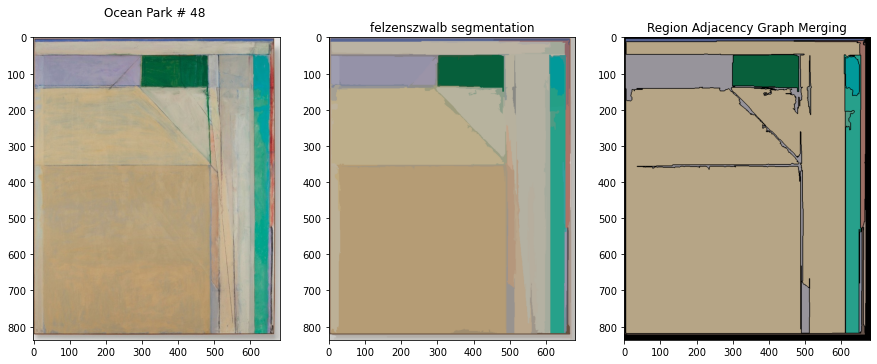

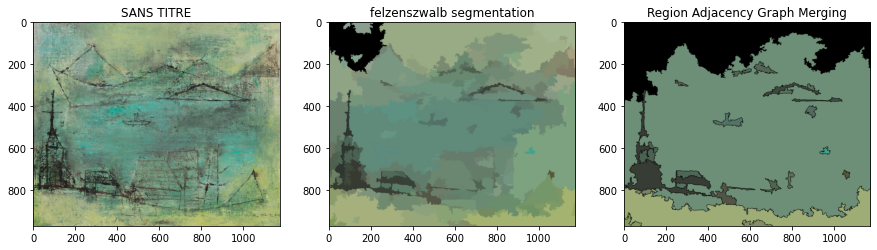

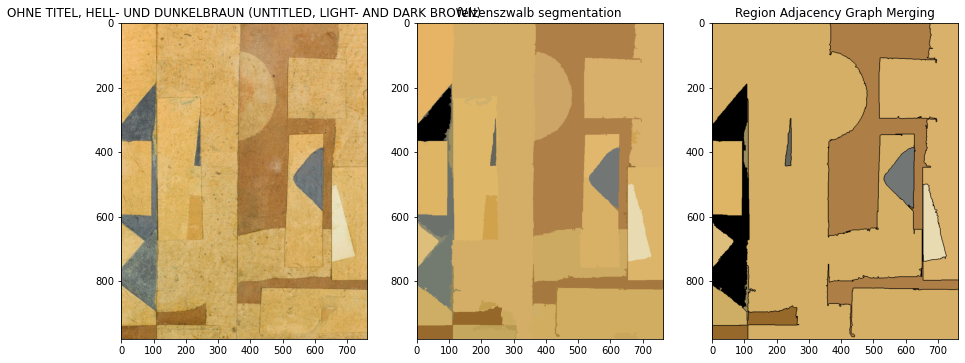

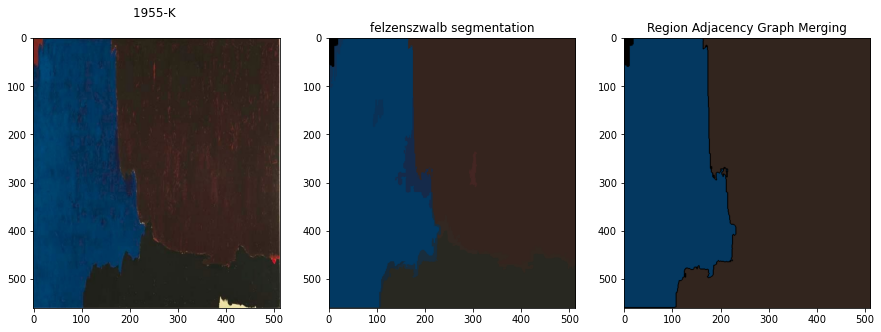

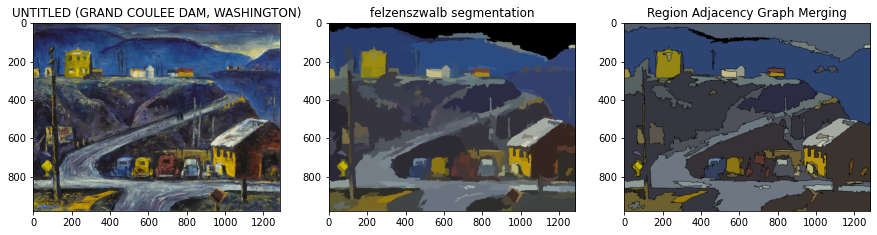

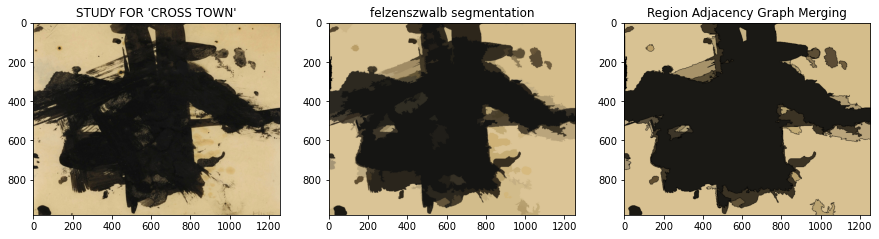

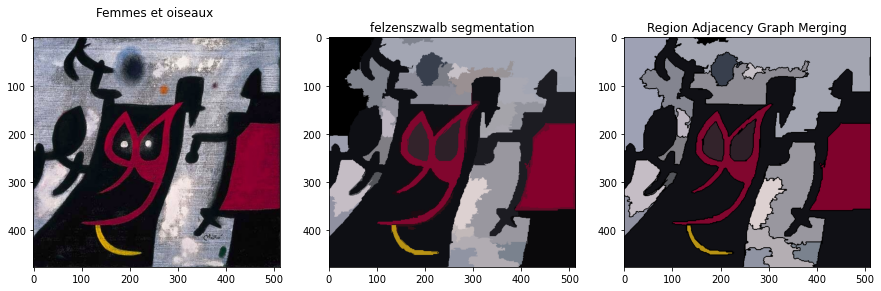

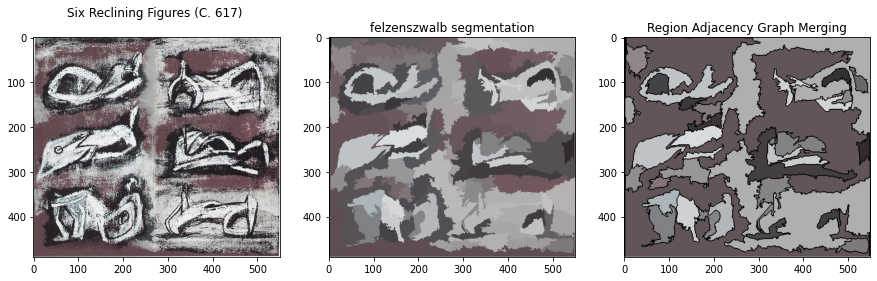

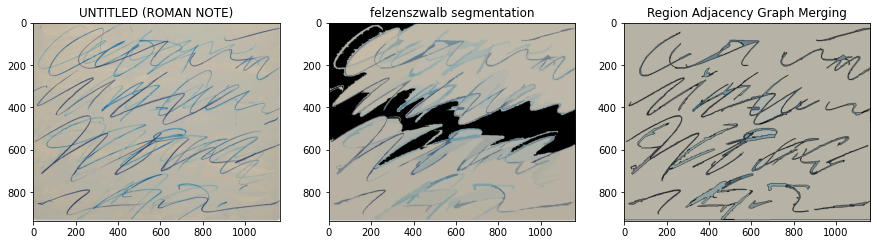

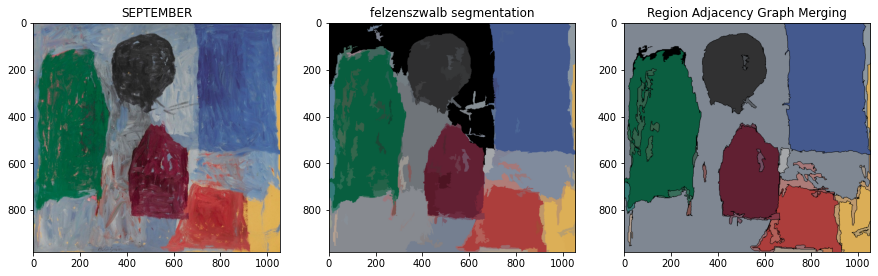

In [5]:
for i in np.random.choice(df.shape[0], 10):
    plot_segment(i)

In [5]:
def get_segmentation(i):
    image = cv2.imread(df.Paths[i])[:,:,::-1]
    image_felzenszwalb = seg.felzenszwalb(image, min_size = 600, scale = 200) 
    image_felzenszwalb_colored = (color.label2rgb(image_felzenszwalb, image, kind='avg', bg_label = 0)* 255).astype(np.uint8)
    g = graph.rag_mean_color(image, image_felzenszwalb)
    labels_merged = graph.merge_hierarchical(image_felzenszwalb, g, thresh=40, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
    
    out = color.label2rgb(labels_merged, image, kind='avg', bg_label=0)
    out = segmentation.mark_boundaries(out, labels_merged, (0, 0, 0))
    return (out).astype(np.uint8)

In [11]:
def get_hsv_of_segment(pixel, image,im_segmented):
    segment = image[np.all(im_segmented == pixel, axis=-1)]
    segment_mean_h = np.mean(segment[:, 0])
    segment_mean_s = np.mean(segment[:, 1])
    segment_mean_v = np.mean(segment[:, 2])
    return np.array([segment_mean_h, segment_mean_s, segment_mean_v])


def segment_analysis(i):
    if i % 100 == 0:
        print(i)
    collected_data = np.array([])
    
    im = cv2.cvtColor(cv2.imread(df.Paths[i]), cv2.COLOR_BGR2HSV)
    try:
        im_segmented = cv2.cvtColor(get_segmentation(i), cv2.COLOR_RGB2HSV)
    except Exception:
        return -np.ones(14)
    u, count = np.unique(
        im_segmented.reshape(-1, im_segmented.shape[2]), axis=0, return_counts=True
    )
    sorted_count = np.argsort(-count)
    
    fls_pixel = u[sorted_count][0]
    fls_hsv = get_hsv_of_segment(fls_pixel, im, im_segmented)
    collected_data = np.concatenate((collected_data, fls_hsv))
    mask_fls = np.all(im_segmented == fls_pixel, axis=-1)
    bound_fls = segmentation.find_boundaries(mask_fls.astype(np.uint8), mode="thick")
    
    area_of_fls = np.sum(mask_fls.astype(np.uint8)) / np.sum(count)
    number_of_segments = int(u.size / 3)
    perimeter_fls = np.sum(bound_fls) / mask_fls.shape[0]
    shape_complexity_fls = perimeter_fls * perimeter_fls / (4 * np.pi * area_of_fls)
    
    area_of_sls, shape_complexity_sls,contrast_h,contrast_s,contrast_v = 0, 0, 0, 0, 0
    if np.shape(u)[0] > 1:
        bound_expanded = segmentation.expand_labels(bound_fls, distance=2)
        im_bound = im_segmented[bound_expanded]
        adj_pixels_with_fls = np.unique(im_bound, axis=0)
        index_of_fls_pixel = adj_pixels_with_fls.tolist().index(list(fls_pixel))
        adj_pixels = np.delete(adj_pixels_with_fls, index_of_fls_pixel, axis=0)
        hsv_adj_segments = [get_hsv_of_segment(pixel, im, im_segmented) for pixel in adj_pixels]
        diff_hsv = np.abs(fls_hsv - hsv_adj_segments)

        contrast_h = np.max(diff_hsv[:, 0])
        contrast_s = np.max(diff_hsv[:, 1])
        contrast_v = np.max(diff_hsv[:, 2])
    
    
        sls_pixel = u[sorted_count][1]
        sls_hsv = get_hsv_of_segment(sls_pixel, im, im_segmented)
        collected_data = np.concatenate((collected_data, sls_hsv))
        
        mask_sls = np.all(im_segmented == sls_pixel, axis=-1)
        area_of_sls = np.sum(mask_sls.astype(np.uint8)) / np.sum(count)
        bound_sls = segmentation.find_boundaries(mask_sls, mode="thick")
        perimeter_sls = np.sum(bound_sls) / mask_sls.shape[0]
        shape_complexity_sls = perimeter_sls * perimeter_sls / (4 * np.pi * area_of_sls)
    else:
        collected_data = np.concatenate((collected_data, [0,0,0]))


    collected_data = np.concatenate(
        (
            collected_data,
            [
                contrast_h,
                contrast_s,
                contrast_v,
                area_of_fls,
                area_of_sls,
                number_of_segments,
                shape_complexity_fls,
                shape_complexity_sls,
            ],
        )
    )
    return collected_data

In [12]:
%%time
segment_data = pd.DataFrame(
    [segment_analysis(j) for j in range(df.shape[0])],
    columns=[
        "fls_h",
        "fls_s",
        "fls_v",
        "sls_h",
        "sls_s",
        "sls_v",
        "contrast_h",
        "contrast_s",
        "contrast_v",
        "area_of_fls",
        "area_of_sls",
        "number_of_segments",
        "shape_complexity_fls",
        "shape_complexity_sls",
    ],
)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
CPU times: user 7h 52min 16s, sys: 3min 13s, total: 7h 55min 29s
Wall time: 7h 53min 49s


In [15]:
segment_data[segment_data.number_of_segments == -1]

,fls_h,fls_s,fls_v,sls_h,sls_s,sls_v,contrast_h,contrast_s,contrast_v,area_of_fls,area_of_sls,number_of_segments,shape_complexity_fls,shape_complexity_sls
3885,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3946,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [22]:
import pickle

df.join(segment_data).to_pickle("/home/maksim/Documents/new_abstract_8.pkl")

# Saliency detection

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import skimage.segmentation as seg
import skimage.color as color
import pickle

In [8]:
df = pd.read_pickle("/home/maksim/Documents/Itten_files/new_abstract_8.pkl")
df.columns

Index(['Art', 'Author', 'Paths', 'normalized_price', 'square_m',
       'ExhibitedNum', 'ProvenanceNum', 'LiteratureNum', 'date_of_birth',
       'oil', 'ink', 'gouache', 'lithograph', 'canvas', 'paper', 'Christie's',
       'Sotheby's', 'Sign', 'салатовый', 'зеленый', 'бирюзовый', 'синий',
       'темно-синий', 'фиолетовый', 'розовый', 'красный', 'ярко-оранжевый',
       'оранжевый', 'ярко-желтый', 'желтый', 'error', 'lines_variance',
       'X_contrst_triad', 'X_classic_triad', 'X_rectangle', 'X_analog_triad',
       'X_quad', 'X_comp', 'ccm', 'points_of_interest', 'mean_h', 'mean_s',
       'mean_v', 'edge_density', 'fls_h', 'fls_s', 'fls_v', 'sls_h', 'sls_s',
       'sls_v', 'contrast_h', 'contrast_s', 'contrast_v', 'area_of_fls',
       'area_of_sls', 'number_of_segments', 'shape_complexity_fls',
       'shape_complexity_sls'],
      dtype='object')

In [11]:
saliency = cv2.saliency.ObjectnessBING_create()
saliency.setTrainingPath('/home/maksim/Downloads/ObjectnessTrainedModel/')

def get_saliency(i):
    image = cv2.imread(df.Paths[i])[:,:,::-1]
    (success, saliencyMap) = saliency.computeSaliency(image)
    numDetections = saliencyMap.shape[0]
    (startX, startY, endX, endY) = saliencyMap[0].flatten()
    return (startX, startY, endX, endY) 
    
def plot_saliency(i):
    image = cv2.imread(df.Paths[i])[:,:,::-1]
    (startX, startY, endX, endY) = get_saliency(i)

    output = image.copy()
    cv2.rectangle(output, (startX, startY), (endX, endY), [255,255,255], 15)
    

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(output)
    axarr[1].imshow(image[startY:endY,startX:endX])    

In [ ]:
for i in np.random.choice(4000, 10):
    plot_saliency(i)